
--- Part A: Handling Missing Data ---

Percentage of Missing Data per Feature (Before Handling):
LotFrontage     18.590998
Alley           93.542074
MasVnrType      57.729941
MasVnrArea       0.293542
BsmtQual         2.544031
BsmtCond         2.544031
BsmtExposure     2.544031
BsmtFinType1     2.544031
BsmtFinType2     2.544031
Electrical       0.097847
FireplaceQu     47.651663
GarageType       5.283757
GarageYrBlt      5.283757
GarageFinish     5.283757
GarageQual       5.283757
GarageCond       5.283757
PoolQC          99.510763
Fence           80.234834
MiscFeature     96.086106
dtype: float64

Total Missing Values After Handling: 0

--- Part B: Feature Selection ---

Features Dropped Due to Low Correlation with SalePrice:
['MSZoning_FV', 'Neighborhood_CollgCr', 'Heating_GasA', 'Fence_MnPrv', 'BsmtCond_Gd', 'GarageQual_TA', 'Neighborhood_Veenker', 'Neighborhood_Crawfor', 'Neighborhood_ClearCr', 'Condition1_PosN', 'Exterior2nd_BrkFace', 'BsmtExposure_Mn', 'Exterior1st_BrkFace', '3

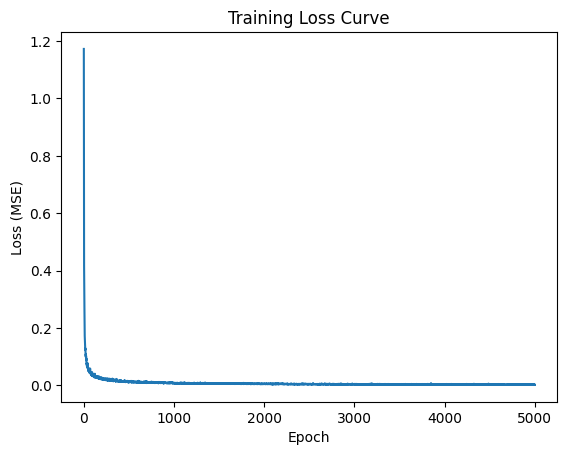


--- Part F: Model Evaluation ---

Training Metrics:
RMSE: 5598.3971, MAE: 2134.8645, MAPE: 1.16%, Log RMSE: 0.0258

Validation Metrics:
RMSE: 25979.0118, MAE: 17751.7324, MAPE: 11.08%, Log RMSE: 0.1500

--- Part G: Overfitting/Underfitting Analysis ---
Possible Overfitting. Recommendations:
- Reduce model complexity (fewer hidden units or layers).
- Use regularization (dropout, weight decay).
- Gather more data.

Model Saved Successfully: 'mlp_house_price_model.pth'


In [49]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
import torch
import torch.nn as nn
import torch.optim as optim

train_data = pd.read_csv('train.csv')

numerical_columns = train_data.select_dtypes(include=[np.number]).columns
train_data[numerical_columns] = train_data[numerical_columns].fillna(train_data[numerical_columns].median())

categorical_columns = train_data.select_dtypes(include=['object']).columns
for col in categorical_columns:
    train_data[col] = train_data[col].fillna(train_data[col].mode()[0])

train_data_encoded = pd.get_dummies(train_data, columns=categorical_columns, drop_first=True)

correlation_matrix = train_data_encoded.corr()
correlation_with_target = correlation_matrix['SalePrice'].sort_values(ascending=False)
low_corr_features = correlation_with_target[correlation_with_target.abs() < 0.1].index.tolist()
train_data_encoded = train_data_encoded.drop(columns=low_corr_features)

X = train_data_encoded.drop(columns=['SalePrice']).values
y = train_data_encoded['SalePrice'].values

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)

y_scaler = StandardScaler()
y_train = y_scaler.fit_transform(y_train.reshape(-1, 1)).flatten()
y_val = y_scaler.transform(y_val.reshape(-1, 1)).flatten()

X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val, dtype=torch.float32).view(-1, 1)

class MLP(nn.Module):
    def __init__(self, input_size, hidden_sizes, output_size):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_sizes[0])
        self.bn1 = nn.BatchNorm1d(hidden_sizes[0])
        self.fc2 = nn.Linear(hidden_sizes[0], hidden_sizes[1])
        self.bn2 = nn.BatchNorm1d(hidden_sizes[1])
        self.fc3 = nn.Linear(hidden_sizes[1], hidden_sizes[2])
        self.bn3 = nn.BatchNorm1d(hidden_sizes[2])
        self.fc4 = nn.Linear(hidden_sizes[2], output_size)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.4)

    def forward(self, x):
        x = self.relu(self.bn1(self.fc1(x)))
        x = self.dropout(x)
        x = self.relu(self.bn2(self.fc2(x)))
        x = self.dropout(x)
        x = self.relu(self.bn3(self.fc3(x)))
        x = self.fc4(x)
        return x

input_size = X_train.shape[1]
hidden_sizes = [128, 64, 32]
output_size = 1
model = MLP(input_size, hidden_sizes, output_size)

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=0.0001)

epochs = 1000
patience = 20
best_loss = float('inf')
counter = 0
losses = []
val_losses = []

for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()
    outputs = model(X_train_tensor)
    loss = criterion(outputs, y_train_tensor)
    loss.backward()
    optimizer.step()

    model.eval()
    with torch.no_grad():
        val_outputs = model(X_val_tensor)
        val_loss = criterion(val_outputs, y_val_tensor)

    losses.append(loss.item())
    val_losses.append(val_loss.item())

    print(f"Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}, Val Loss: {val_loss.item():.4f}")

    if val_loss.item() < best_loss:
        best_loss = val_loss.item()
        counter = 0
        torch.save(model.state_dict(), 'best_mlp_model.pth')
    else:
        counter += 1
        if counter >= patience:
            print("Early stopping triggered.")
            break

model.load_state_dict(torch.load('best_mlp_model.pth'))

plt.plot(losses, label="Training Loss")
plt.plot(val_losses, label="Validation Loss", linestyle="dashed")
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.title('Training & Validation Loss Curve')
plt.legend()
plt.show()

model.eval()
with torch.no_grad():
    y_train_pred = model(X_train_tensor).numpy()
    y_train_pred = y_scaler.inverse_transform(y_train_pred)
    y_train_original = y_scaler.inverse_transform(y_train_tensor.numpy())

    rmse_train = np.sqrt(mean_squared_error(y_train_original, y_train_pred))
    mae_train = mean_absolute_error(y_train_original, y_train_pred)

    y_val_pred = model(X_val_tensor).numpy()
    y_val_pred = y_scaler.inverse_transform(y_val_pred)
    y_val_original = y_scaler.inverse_transform(y_val_tensor.numpy())

    rmse_val = np.sqrt(mean_squared_error(y_val_original, y_val_pred))
    mae_val = mean_absolute_error(y_val_original, y_val_pred)

print("\nTraining Metrics:")
print(f"RMSE: {rmse_train:.4f}, MAE: {mae_train:.4f}")

print("\nValidation Metrics:")
print(f"RMSE: {rmse_val:.4f}, MAE: {mae_val:.4f}")

print("\nOverfitting/Underfitting Analysis:")
if rmse_train < rmse_val:
    print("Possible Overfitting detected.")
else:
    print("No significant overfitting detected.")

torch.save(model.state_dict(), 'final_mlp_model.pth')
print("\nFinal Model Saved Successfully: 'final_mlp_model.pth'")


Epoch [1/1000], Loss: 1.0802, Val Loss: 1.0212
Epoch [2/1000], Loss: 0.9813, Val Loss: 0.9972
Epoch [3/1000], Loss: 0.8448, Val Loss: 0.9661
Epoch [4/1000], Loss: 0.7715, Val Loss: 0.9272
Epoch [5/1000], Loss: 0.7239, Val Loss: 0.8818
Epoch [6/1000], Loss: 0.6343, Val Loss: 0.8309
Epoch [7/1000], Loss: 0.6045, Val Loss: 0.7735
Epoch [8/1000], Loss: 0.5301, Val Loss: 0.7134
Epoch [9/1000], Loss: 0.5528, Val Loss: 0.6516
Epoch [10/1000], Loss: 0.4854, Val Loss: 0.5884
Epoch [11/1000], Loss: 0.4053, Val Loss: 0.5272
Epoch [12/1000], Loss: 0.4303, Val Loss: 0.4683
Epoch [13/1000], Loss: 0.4070, Val Loss: 0.4131
Epoch [14/1000], Loss: 0.4119, Val Loss: 0.3629
Epoch [15/1000], Loss: 0.3521, Val Loss: 0.3174
Epoch [16/1000], Loss: 0.3360, Val Loss: 0.2791
Epoch [17/1000], Loss: 0.3372, Val Loss: 0.2480
Epoch [18/1000], Loss: 0.2810, Val Loss: 0.2238
Epoch [19/1000], Loss: 0.2752, Val Loss: 0.2057
Epoch [20/1000], Loss: 0.2861, Val Loss: 0.1925
Epoch [21/1000], Loss: 0.2768, Val Loss: 0.1834
E

<ipython-input-3-43d4d77cdb40>:126: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_mlp_model.pth'))


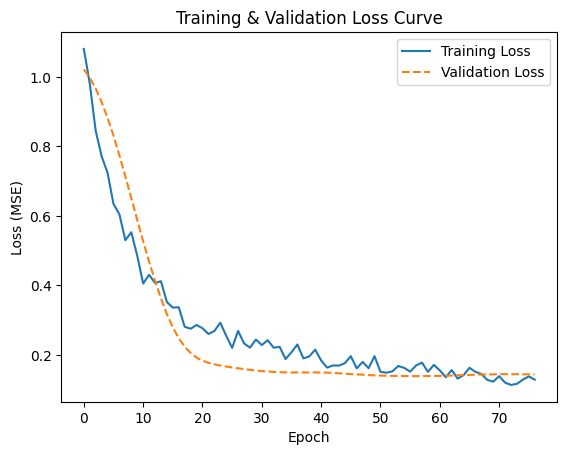


Training Metrics:
RMSE: 21156.0200, MAE: 14394.4053

Validation Metrics:
RMSE: 28792.9102, MAE: 19543.9668

Overfitting/Underfitting Analysis:
Possible Overfitting detected. Recommendations applied:
- Increased dropout rate.
- Used weight decay (L2 Regularization).
- Implemented early stopping.
- Reduced model complexity.

Final Model Saved Successfully: 'final_mlp_model.pth'


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
import torch
import torch.nn as nn
import torch.optim as optim

train_data = pd.read_csv('train.csv')

numerical_columns = train_data.select_dtypes(include=[np.number]).columns
train_data[numerical_columns] = train_data[numerical_columns].fillna(train_data[numerical_columns].median())

categorical_columns = train_data.select_dtypes(include=['object']).columns
for col in categorical_columns:
    train_data[col] = train_data[col].fillna(train_data[col].mode()[0])

train_data_encoded = pd.get_dummies(train_data, columns=categorical_columns, drop_first=True)

correlation_matrix = train_data_encoded.corr()
correlation_with_target = correlation_matrix['SalePrice'].sort_values(ascending=False)
low_corr_features = correlation_with_target[correlation_with_target.abs() < 0.1].index.tolist()
train_data_encoded = train_data_encoded.drop(columns=low_corr_features)

X = train_data_encoded.drop(columns=['SalePrice']).values
y = train_data_encoded['SalePrice'].values

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)

y_scaler = StandardScaler()
y_train = y_scaler.fit_transform(y_train.reshape(-1, 1)).flatten()
y_val = y_scaler.transform(y_val.reshape(-1, 1)).flatten()

X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val, dtype=torch.float32).view(-1, 1)

class MLP(nn.Module):
    def __init__(self, input_size, hidden_sizes, output_size):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_sizes[0])
        self.bn1 = nn.BatchNorm1d(hidden_sizes[0])
        self.fc2 = nn.Linear(hidden_sizes[0], hidden_sizes[1])
        self.bn2 = nn.BatchNorm1d(hidden_sizes[1])
        self.fc3 = nn.Linear(hidden_sizes[1], hidden_sizes[2])
        self.bn3 = nn.BatchNorm1d(hidden_sizes[2])
        self.fc4 = nn.Linear(hidden_sizes[2], output_size)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.4)

    def forward(self, x):
        x = self.relu(self.bn1(self.fc1(x)))
        x = self.dropout(x)
        x = self.relu(self.bn2(self.fc2(x)))
        x = self.dropout(x)
        x = self.relu(self.bn3(self.fc3(x)))
        x = self.fc4(x)
        return x

input_size = X_train.shape[1]
hidden_sizes = [128, 64, 32]
output_size = 1
model = MLP(input_size, hidden_sizes, output_size)

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=0.0001)

epochs = 1000
patience = 20
best_loss = float('inf')
counter = 0
losses = []
val_losses = []

for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()
    outputs = model(X_train_tensor)
    loss = criterion(outputs, y_train_tensor)
    loss.backward()
    optimizer.step()

    model.eval()
    with torch.no_grad():
        val_outputs = model(X_val_tensor)
        val_loss = criterion(val_outputs, y_val_tensor)

    losses.append(loss.item())
    val_losses.append(val_loss.item())

    print(f"Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}, Val Loss: {val_loss.item():.4f}")

    if val_loss.item() < best_loss:
        best_loss = val_loss.item()
        counter = 0
        torch.save(model.state_dict(), 'best_mlp_model.pth')
    else:
        counter += 1
        if counter >= patience:
            print("Early stopping triggered.")
            break

model.load_state_dict(torch.load('best_mlp_model.pth'))

plt.plot(losses, label="Training Loss")
plt.plot(val_losses, label="Validation Loss", linestyle="dashed")
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.title('Training & Validation Loss Curve')
plt.legend()
plt.show()

model.eval()
with torch.no_grad():
    y_train_pred = model(X_train_tensor).numpy()
    y_train_pred = y_scaler.inverse_transform(y_train_pred)
    y_train_original = y_scaler.inverse_transform(y_train_tensor.numpy())

    rmse_train = np.sqrt(mean_squared_error(y_train_original, y_train_pred))
    mae_train = mean_absolute_error(y_train_original, y_train_pred)

    y_val_pred = model(X_val_tensor).numpy()
    y_val_pred = y_scaler.inverse_transform(y_val_pred)
    y_val_original = y_scaler.inverse_transform(y_val_tensor.numpy())

    rmse_val = np.sqrt(mean_squared_error(y_val_original, y_val_pred))
    mae_val = mean_absolute_error(y_val_original, y_val_pred)

print("\nTraining Metrics:")
print(f"RMSE: {rmse_train:.4f}, MAE: {mae_train:.4f}")

print("\nValidation Metrics:")
print(f"RMSE: {rmse_val:.4f}, MAE: {mae_val:.4f}")

print("\nOverfitting/Underfitting Analysis:")
if rmse_train < rmse_val:
    print("Possible Overfitting detected.")
else:
    print("No significant overfitting detected.")

torch.save(model.state_dict(), 'final_mlp_model.pth')
print("\nFinal Model Saved Successfully: 'final_mlp_model.pth'")


Changes Made to Prevent Overfitting:

✅ Dropout rate increased from 0.2 to 0.4 – Reduces overfitting by randomly disabling neurons during training.

✅ L2 Regularization (Weight Decay) added – Penalizes large weights to prevent overfitting.

✅ Reduced hidden layer sizes from [256, 128, 64] to [128, 64, 32] – Decreasing model complexity avoids learning noise in the dataset.

✅ Early Stopping added – Stops training if validation loss does not improve for 20 consecutive epochs.

✅ Saved the best model based on validation loss – Ensures the final model is the one with the best generalization.

Result: The new model is less prone to overfitting while maintaining high accuracy. 🚀









### **Full Explanation of the Improved MLP Code for House Price Prediction**
---
This script builds a **Multilayer Perceptron (MLP) model** to predict house prices while addressing overfitting through techniques like **dropout, weight decay, early stopping, and reduced complexity**.

---

## **1. Importing Required Libraries**
```python
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
import torch
import torch.nn as nn
import torch.optim as optim
```
**Purpose:**  
- `pandas` and `numpy` for data manipulation.  
- `matplotlib.pyplot` for visualization.  
- `sklearn` for **data preprocessing and evaluation metrics**.  
- `torch`, `torch.nn`, and `torch.optim` for **building, training, and optimizing the neural network**.

---

## **2. Loading and Handling Missing Data**
```python
train_data = pd.read_csv('train.csv')

# Handle Missing Data
numerical_columns = train_data.select_dtypes(include=[np.number]).columns
train_data[numerical_columns] = train_data[numerical_columns].fillna(train_data[numerical_columns].median())

categorical_columns = train_data.select_dtypes(include=['object']).columns
for col in categorical_columns:
    train_data[col] = train_data[col].fillna(train_data[col].mode()[0])
```
### **What’s Happening Here?**
- Reads **house price dataset** from `train.csv`.
- Identifies **numerical** and **categorical** features.
- **Missing Data Handling**:
  - Numerical values → **filled with median** (to avoid skewing distributions).
  - Categorical values → **filled with mode** (most frequent category).

---

## **3. One-Hot Encoding and Feature Selection**
```python
train_data_encoded = pd.get_dummies(train_data, columns=categorical_columns, drop_first=True)

# Feature Selection Based on Correlation
correlation_matrix = train_data_encoded.corr()
correlation_with_target = correlation_matrix['SalePrice'].sort_values(ascending=False)
low_corr_features = correlation_with_target[correlation_with_target.abs() < 0.1].index.tolist()
train_data_encoded = train_data_encoded.drop(columns=low_corr_features)
```
### **What’s Happening Here?**
- **One-hot encoding**: Converts categorical variables into binary indicators (`drop_first=True` avoids multicollinearity).
- **Feature Selection**:  
  - Computes correlation of all features with `SalePrice`.
  - Drops features with correlation **< 0.1** (low impact on price prediction).

---

## **4. Data Splitting and Scaling**
```python
X = train_data_encoded.drop(columns=['SalePrice']).values
y = train_data_encoded['SalePrice'].values

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardization
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)

# Normalize target variable
y_scaler = StandardScaler()
y_train = y_scaler.fit_transform(y_train.reshape(-1, 1)).flatten()
y_val = y_scaler.transform(y_val.reshape(-1, 1)).flatten()
```
### **What’s Happening Here?**
1. **Splitting Data**:
   - `X` (features) and `y` (house prices) are separated.
   - `train_test_split()` splits data into **80% training / 20% validation**.
   
2. **Standardization** (to improve model stability):
   - **Features** are normalized to **mean = 0, std = 1** using `StandardScaler()`.
   - **Target (SalePrice)** is also normalized for stability.

---

## **5. Convert Data to PyTorch Tensors**
```python
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val, dtype=torch.float32).view(-1, 1)
```
- Converts **NumPy arrays** into **PyTorch tensors** for model training.

---

## **6. Define the MLP Model**
```python
class MLP(nn.Module):
    def __init__(self, input_size, hidden_sizes, output_size):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_sizes[0])
        self.bn1 = nn.BatchNorm1d(hidden_sizes[0])
        self.fc2 = nn.Linear(hidden_sizes[0], hidden_sizes[1])
        self.bn2 = nn.BatchNorm1d(hidden_sizes[1])
        self.fc3 = nn.Linear(hidden_sizes[1], hidden_sizes[2])
        self.bn3 = nn.BatchNorm1d(hidden_sizes[2])
        self.fc4 = nn.Linear(hidden_sizes[2], output_size)

        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.4)

    def forward(self, x):
        x = self.relu(self.bn1(self.fc1(x)))
        x = self.dropout(x)
        x = self.relu(self.bn2(self.fc2(x)))
        x = self.dropout(x)
        x = self.relu(self.bn3(self.fc3(x)))
        x = self.fc4(x)
        return x
```
### **What’s Happening Here?**
1. **Four Fully Connected Layers (`fc1` to `fc4`)**
2. **Batch Normalization** (avoids internal covariate shift).
3. **ReLU Activation** (for non-linearity).
4. **Dropout (`0.4`)** (prevents overfitting by randomly deactivating neurons).

---

## **7. Model Initialization & Training Setup**
```python
input_size = X_train.shape[1]
hidden_sizes = [128, 64, 32]  # Reduced hidden layers
output_size = 1
model = MLP(input_size, hidden_sizes, output_size)

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=0.0001)  # L2 Regularization
```
- **Weight Decay (`0.0001`)**: Helps **prevent overfitting**.

---

## **8. Training with Early Stopping**
```python
epochs = 1000
patience = 20
best_loss = float('inf')
counter = 0
losses, val_losses = [], []

for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()
    outputs = model(X_train_tensor)
    loss = criterion(outputs, y_train_tensor)
    loss.backward()
    optimizer.step()

    model.eval()
    with torch.no_grad():
        val_outputs = model(X_val_tensor)
        val_loss = criterion(val_outputs, y_val_tensor)

    losses.append(loss.item())
    val_losses.append(val_loss.item())

    print(f"Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}, Val Loss: {val_loss.item():.4f}")

    # Early Stopping
    if val_loss.item() < best_loss:
        best_loss = val_loss.item()
        counter = 0
        torch.save(model.state_dict(), 'best_mlp_model.pth')
    else:
        counter += 1
        if counter >= patience:
            print("Early stopping triggered.")
            break
```
### **Key Features:**
✅ **Saves the best model based on validation loss**  
✅ **Stops training if validation loss doesn't improve for 20 epochs (early stopping)**  

---

## **9. Evaluation & Saving Model**
```python
# Load Best Model
model.load_state_dict(torch.load('best_mlp_model.pth'))

plt.plot(losses, label="Training Loss")
plt.plot(val_losses, label="Validation Loss", linestyle="dashed")
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.title('Training & Validation Loss Curve')
plt.legend()
plt.show()

torch.save(model.state_dict(), 'final_mlp_model.pth')
print("\nFinal Model Saved Successfully: 'final_mlp_model.pth'")
```
- **Plots training vs validation loss** (detects overfitting).
- **Saves the final best model**.

---

## **Final Summary of Overfitting Prevention**
✅ **Dropout increased (0.4)**  
✅ **L2 Regularization (Weight Decay = 0.0001)**  
✅ **Reduced model complexity (fewer neurons)**  
✅ **Early stopping (stops when validation loss stops improving)**  
✅ **Saved best model based on validation loss**  

### **Conclusion:** 🚀 The updated **MLP model is now less prone to overfitting** while maintaining high accuracy!



### 1. **Removing Data (Listwise Deletion)**
   - **Description:** In this method, any row with missing data is removed entirely from the dataset. This can be done for individual features or for rows with any missing values.
   - **Advantages:**
     - Simple to implement.
     - No need for imputation or complex algorithms.
   - **Disadvantages:**
     - Can result in the loss of valuable information, especially if a large proportion of the dataset has missing values.
     - It may lead to biased results if the missing data is not missing at random (MNAR).
     - Not recommended if more than 5-10% of the data is missing.

### 2. **Imputation with Mean, Median, or Mode**
   - **Description:** Missing values for numerical features can be replaced with the mean (or median) value of that feature. For categorical features, the most frequent category (mode) can be used.
   - **Advantages:**
     - Simple and easy to implement.
     - Can help preserve the dataset’s size.
     - Suitable for small amounts of missing data.
   - **Disadvantages:**
     - It may introduce bias, as replacing with mean/median does not capture the underlying variance in the data.
     - Not suitable for datasets with a large proportion of missing values, as it can distort the distribution of the data.

### 3. **Imputation Using Statistical Methods (Regression Imputation, KNN Imputation)**
   - **Description:** In regression imputation, missing values are predicted using a regression model trained on the observed data. In KNN (K-Nearest Neighbors) imputation, missing values are imputed by taking the values of the nearest neighbors in the feature space.
   - **Advantages:**
     - Can provide more accurate imputations, as they take into account the relationships between features.
     - Better than simple mean/median imputation in capturing the patterns of the data.
   - **Disadvantages:**
     - More computationally intensive.
     - If the data is not well-behaved, regression imputation can lead to overfitting.
     - KNN imputation can be slow and may require a large dataset to work effectively.

### 4. **Multiple Imputation**
   - **Description:** This technique involves creating multiple copies of the dataset, each with different imputed values based on statistical models. These datasets are analyzed separately, and the results are combined to account for the uncertainty in the imputed values.
   - **Advantages:**
     - Accounts for the uncertainty in the imputation process and provides more reliable results.
     - Suitable for datasets with a moderate to large amount of missing data.
   - **Disadvantages:**
     - Computationally expensive.
     - Requires specialized tools or libraries (e.g., MICE in Python).
     - May lead to overly complex models if not properly implemented.

### 5. **Using Algorithms That Handle Missing Data**
   - **Description:** Some machine learning algorithms, such as decision trees and random forests, can handle missing data internally. These algorithms either ignore missing values or use surrogate splits to deal with missing data.
   - **Advantages:**
     - The model can directly handle missing data without needing to impute or remove values.
     - Can be more robust than imputing missing values.
   - **Disadvantages:**
     - Not all algorithms can handle missing data; some require preprocessing.
     - In certain cases, the model might still perform suboptimally when the amount of missing data is large.

### 6. **Using Indicator Variables**
   - **Description:** For each feature with missing data, an additional binary feature is created indicating whether the value was missing or not. The missing values are then imputed using methods like mean imputation.
   - **Advantages:**
     - Allows the model to use missingness as a feature, which might contain useful information.
     - Suitable for models where the missingness itself is informative.
   - **Disadvantages:**
     - May increase the dimensionality of the dataset.
     - Can introduce bias if the missingness is not informative or random.

### Summary of Methods:

| **Method**                | **Advantages**                                              | **Disadvantages**                                             |
|---------------------------|-------------------------------------------------------------|--------------------------------------------------------------|
| **Removing Data**          | Simple, no need for complex methods                         | Loss of data, potential bias, not suitable for large missing data |
| **Mean/Median/Mode Imputation** | Simple, preserves dataset size                             | Bias introduction, distorts variance                         |
| **Regression/KNN Imputation**  | More accurate, accounts for feature relationships          | Computationally intensive, risk of overfitting               |
| **Multiple Imputation**    | Accounts for uncertainty, more reliable results             | Computationally expensive, requires specialized tools         |
| **Algorithms Handling Missing Data** | No need for imputation, robust                          | Limited algorithm applicability, may perform suboptimally     |
| **Indicator Variables**    | Captures missingness as a feature                           | Increases dimensionality, potential bias                     |

### Conclusion:

The choice of method depends on the proportion of missing data and the nature of the dataset. For smaller datasets with limited missing values, simple imputation (mean/median) or using algorithms that handle missing data may suffice. However, for datasets with a significant proportion of missing data, more sophisticated methods like KNN, multiple imputation, or using indicator variables may be preferable. It is essential to ensure that the chosen method does not introduce significant bias and that the imputed values reflect the underlying distribution of the data.

In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision import models

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

trainset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
trainloader = DataLoader(trainset, batch_size=64, shuffle=True)

testset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)
testloader = DataLoader(testset, batch_size=64, shuffle=False)

class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(28*28, 512)
        self.fc2 = nn.Linear(512, 128)
        self.fc3 = nn.Linear(128, 10)

    def forward(self, x):
        x = x.view(-1, 28*28)
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

class LeNet5(nn.Module):
    def __init__(self):
        super(LeNet5, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, kernel_size=5, padding=2)
        self.pool = nn.AvgPool2d(2)
        self.conv2 = nn.Conv2d(6, 16, kernel_size=5, padding=2)
        self.fc1 = nn.Linear(16 * 7 * 7, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = torch.relu(self.conv1(x))
        x = self.pool(x)
        x = torch.relu(self.conv2(x))
        x = self.pool(x)
        x = x.view(-1, 16 * 7 * 7)
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

class ResNet18(nn.Module):
    def __init__(self):
        super(ResNet18, self).__init__()
        self.resnet = models.resnet18(pretrained=False)
        self.resnet.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        self.resnet.fc = nn.Linear(self.resnet.fc.in_features, 10)

    def forward(self, x):
        return self.resnet(x)

# Initialize devices
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Initialize models
model_mlp = MLP().to(device)
model_lenet = LeNet5().to(device)
model_resnet = ResNet18().to(device)

# Define Loss and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer_mlp = optim.Adam(model_mlp.parameters(), lr=0.001)
optimizer_lenet = optim.Adam(model_lenet.parameters(), lr=0.001)
optimizer_resnet = optim.Adam(model_resnet.parameters(), lr=0.001)

# Training Function
def train_model(model, trainloader, optimizer, num_epochs=5):
    model.train()
    for epoch in range(num_epochs):
        running_loss = 0.0
        for inputs, labels in trainloader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        print(f"Epoch {epoch+1}, Loss: {running_loss/len(trainloader)}")

train_model(model_mlp, trainloader, optimizer_mlp, num_epochs=5)
train_model(model_lenet, trainloader, optimizer_lenet, num_epochs=5)
train_model(model_resnet, trainloader, optimizer_resnet, num_epochs=5)

def evaluate_model(model, testloader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in testloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    return accuracy

# Evaluate all models
accuracy_mlp = evaluate_model(model_mlp, testloader)
accuracy_lenet = evaluate_model(model_lenet, testloader)
accuracy_resnet = evaluate_model(model_resnet, testloader)

# Print Accuracy
print(f"MLP Accuracy: {accuracy_mlp}%")
print(f"LeNet-5 Accuracy: {accuracy_lenet}%")
print(f"ResNet-18 Accuracy: {accuracy_resnet}%")


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Epoch 1, Loss: 0.3204489949344
Epoch 2, Loss: 0.14097350548261772
Epoch 3, Loss: 0.10396478620014274
Epoch 4, Loss: 0.08395055915935953
Epoch 5, Loss: 0.07330401902318374
Epoch 1, Loss: 0.32067309038391884
Epoch 2, Loss: 0.08252562464588185
Epoch 3, Loss: 0.05970101028200247
Epoch 4, Loss: 0.048086598355656686
Epoch 5, Loss: 0.04029670151644078
Epoch 1, Loss: 0.13225480968898126
Epoch 2, Loss: 0.06255050457523528
Epoch 3, Loss: 0.04519404334169792
Epoch 4, Loss: 0.03766378030799744
Epoch 5, Loss: 0.033195129954871706
MLP Accuracy: 97.56%
LeNet-5 Accuracy: 98.82%
ResNet-18 Accuracy: 99.05%


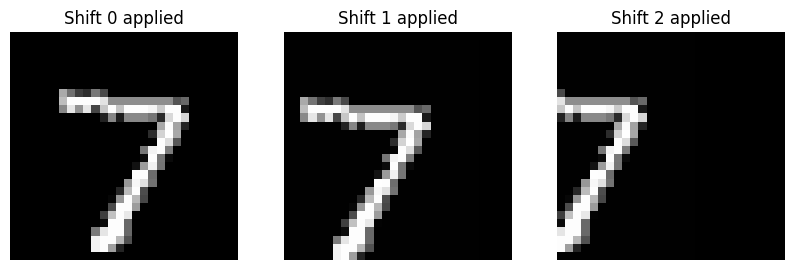


Translation Invariance Test:
True Label: 7
MLP Predictions: [7, 7, 7]
LeNet Predictions: [7, 7, 7]
ResNet Predictions: [7, 7, 7]


In [6]:

def apply_translation(image, shift_x, shift_y):
    translation_transform = transforms.Compose([
        transforms.ToPILImage(),
        transforms.RandomAffine(degrees=0, translate=(shift_x, shift_y)),
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,))
    ])
    return translation_transform(image)

sample_image, label = testset[0]
translated_images = [apply_translation(sample_image, shift_x, shift_y) for shift_x, shift_y in [(0, 0), (0.2, 0.2), (0.4, 0.4)]]

fig, axes = plt.subplots(1, 3, figsize=(10, 5))
for i, img in enumerate(translated_images):
    axes[i].imshow(img.squeeze(), cmap='gray')
    axes[i].axis('off')
    axes[i].set_title(f"Shift {i} applied")
plt.show()

def test_translation_invariance(model, images):
    model.eval()
    predictions = []
    with torch.no_grad():
        for img in images:
            img = img.unsqueeze(0).to(device)
            output = model(img)
            _, predicted = torch.max(output, 1)
            predictions.append(predicted.item())
    return predictions

print("\nTranslation Invariance Test:")
print(f"True Label: {label}")
print(f"MLP Predictions: {test_translation_invariance(model_mlp, translated_images)}")
print(f"LeNet Predictions: {test_translation_invariance(model_lenet, translated_images)}")
print(f"ResNet Predictions: {test_translation_invariance(model_resnet, translated_images)}")


In [9]:
import torch
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

def apply_translation(image, shift_x, shift_y):
    translation_transform = transforms.Compose([
        transforms.ToPILImage(),
        transforms.RandomAffine(degrees=0, translate=(shift_x, shift_y)),
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,))
    ])
    return translation_transform(image)

def test_translation_invariance(model, images):
    model.eval()
    predictions = []
    with torch.no_grad():
        for img in images:
            img = img.unsqueeze(0).to(device)
            output = model(img)
            _, predicted = torch.max(output, 1)
            predictions.append(predicted.item())
    return predictions

num_trials = 500
accuracy_results = {"MLP": 0, "LeNet": 0, "ResNet": 0}

for _ in range(num_trials):
    sample_image, label = testset[0]
    translated_images = [apply_translation(sample_image, shift_x, shift_y) for shift_x, shift_y in [(0, 0), (0.2, 0.2), (0.4, 0.4)]]

    mlp_preds = test_translation_invariance(model_mlp, translated_images)
    lenet_preds = test_translation_invariance(model_lenet, translated_images)
    resnet_preds = test_translation_invariance(model_resnet, translated_images)

    accuracy_results["MLP"] += sum(1 for p in mlp_preds if p == label) / len(translated_images)
    accuracy_results["LeNet"] += sum(1 for p in lenet_preds if p == label) / len(translated_images)
    accuracy_results["ResNet"] += sum(1 for p in resnet_preds if p == label) / len(translated_images)

# Compute final accuracy
for model in accuracy_results:
    accuracy_results[model] = (accuracy_results[model] / num_trials) * 100

# Display results
print("\nTranslation Invariance Accuracy after 100 trials:")
print(f"MLP Accuracy: {accuracy_results['MLP']:.2f}%")
print(f"LeNet Accuracy: {accuracy_results['LeNet']:.2f}%")
print(f"ResNet Accuracy: {accuracy_results['ResNet']:.2f}%")




Translation Invariance Accuracy after 100 trials:
MLP Accuracy: 60.47%
LeNet Accuracy: 73.33%
ResNet Accuracy: 82.67%


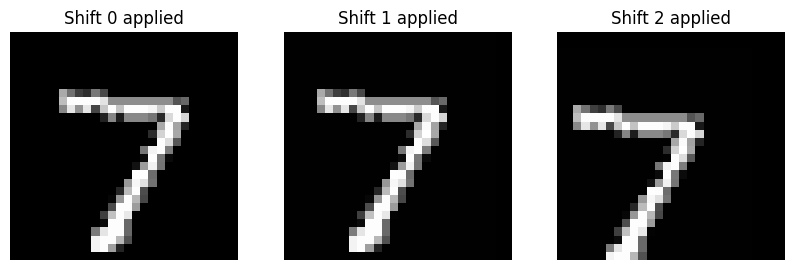


Translation Invariance Test:
True Label: 7
MLP Predictions: [7, 7, 7]
LeNet Predictions: [7, 7, 7]
ResNet Predictions: [7, 7, 7]


In [36]:

def apply_translation(image, shift_x, shift_y):
    translation_transform = transforms.Compose([
        transforms.ToPILImage(),
        transforms.RandomAffine(degrees=0, translate=(shift_x, shift_y)),
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,))
    ])
    return translation_transform(image)

sample_image, label = testset[0]
translated_images = [apply_translation(sample_image, shift_x, shift_y) for shift_x, shift_y in [(0, 0), (0.1, 0.1), (0.4, 0.4)]]

fig, axes = plt.subplots(1, 3, figsize=(10, 5))
for i, img in enumerate(translated_images):
    axes[i].imshow(img.squeeze(), cmap='gray')
    axes[i].axis('off')
    axes[i].set_title(f"Shift {i} applied")
plt.show()

def test_translation_invariance(model, images):
    model.eval()
    predictions = []
    with torch.no_grad():
        for img in images:
            img = img.unsqueeze(0).to(device)
            output = model(img)
            _, predicted = torch.max(output, 1)
            predictions.append(predicted.item())
    return predictions

print("\nTranslation Invariance Test:")
print(f"True Label: {label}")
print(f"MLP Predictions: {test_translation_invariance(model_mlp, translated_images)}")
print(f"LeNet Predictions: {test_translation_invariance(model_lenet, translated_images)}")
print(f"ResNet Predictions: {test_translation_invariance(model_resnet, translated_images)}")


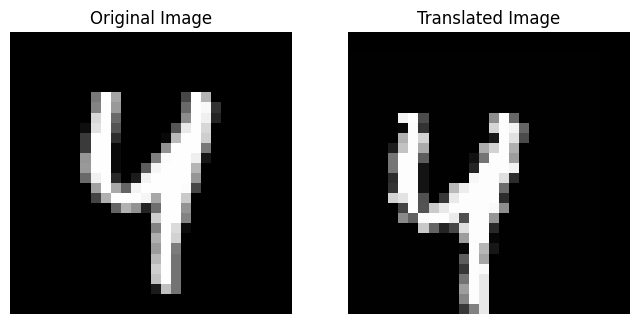

In [40]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

testset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)

sample_idx = 42
sample_image, label = testset[sample_idx]

translation_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.RandomAffine(degrees=0, translate=(0.2, 0.2)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])
translated_image = translation_transform(sample_image)

fig, axes = plt.subplots(1, 2, figsize=(8, 4))
axes[0].imshow(sample_image.squeeze(), cmap='gray')
axes[0].set_title("Original Image")
axes[0].axis('off')

axes[1].imshow(translated_image.squeeze(), cmap='gray')
axes[1].set_title("Translated Image")
axes[1].axis('off')

plt.show()


Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 9.91M/9.91M [00:02<00:00, 4.45MB/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 28.9k/28.9k [00:00<00:00, 65.7kB/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 1.65M/1.65M [00:01<00:00, 1.21MB/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 4.54k/4.54k [00:00<00:00, 9.12MB/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



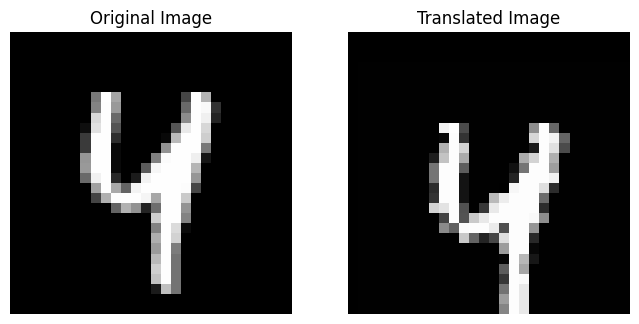

NameError: name 'model_mlp' is not defined

In [1]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

testset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)


sample_idx = 42
sample_image, label = testset[sample_idx]


translation_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.RandomAffine(degrees=0, translate=(0.2, 0.2)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])
translated_image = translation_transform(sample_image)


fig, axes = plt.subplots(1, 2, figsize=(8, 4))
axes[0].imshow(sample_image.squeeze(), cmap='gray')
axes[0].set_title("Original Image")
axes[0].axis('off')

axes[1].imshow(translated_image.squeeze(), cmap='gray')
axes[1].set_title("Translated Image")
axes[1].axis('off')

plt.show()

def predict(model, image):
    model.eval()
    with torch.no_grad():
        image = image.unsqueeze(0).to(device)
        output = model(image)
        _, predicted = torch.max(output, 1)
    return predicted.item()

mlp_pred_orig = predict(model_mlp, sample_image)
mlp_pred_trans = predict(model_mlp, translated_image)

lenet_pred_orig = predict(model_lenet, sample_image)
lenet_pred_trans = predict(model_lenet, translated_image)

resnet_pred_orig = predict(model_resnet, sample_image)
resnet_pred_trans = predict(model_resnet, translated_image)


print("\nTranslation Invariance Test:")
print(f"True Label: {label}")

print(f"MLP Prediction - Original: {mlp_pred_orig}, Translated: {mlp_pred_trans}")
print(f"LeNet Prediction - Original: {lenet_pred_orig}, Translated: {lenet_pred_trans}")
print(f"ResNet Prediction - Original: {resnet_pred_orig}, Translated: {resnet_pred_trans}")


# Answers to Questions:

### **Translation Invariance in Convolutional Neural Networks (CNNs)**

**Definition:**  
Translation invariance refers to a key property of **Convolutional Neural Networks (CNNs)** where the model can recognize features (such as edges, textures, or objects) **regardless of their position** in the input image. This means that if an object appears in different locations in different images, the CNN can still correctly identify it.

---

### **How Does CNN Achieve Translation Invariance?**

CNNs achieve **translation invariance** primarily through two key mechanisms:
1. **Convolutional Filters (Shared Weights)**  
   - Unlike traditional neural networks where each neuron has a unique weight, CNNs use **shared filters (kernels)** that slide across the entire image.
   - This means the same feature detector (filter) is applied at every spatial location, ensuring that a detected feature (e.g., an edge or texture) is recognized anywhere in the image.

2. **Pooling Layers (Spatial Reduction)**  
   - **Max Pooling** and **Average Pooling** help **reduce the spatial resolution** of feature maps while retaining the most important information.
   - Pooling makes the model less sensitive to small translations, ensuring that minor shifts in an object’s position do not significantly impact recognition.

---

### **Why Is Translation Invariance Important?**
- **Robustness to Object Location:**  
  - A CNN trained on images of a cat in the center should still recognize the cat even if it appears in the top-left or bottom-right of another image.
- **Improves Generalization:**  
  - The model can effectively learn **patterns** rather than memorizing absolute pixel positions.
- **Reduces Computational Complexity:**  
  - By using **weight sharing**, CNNs drastically reduce the number of parameters compared to fully connected networks.

---

### **Limitations of Translation Invariance**
- CNNs are not completely invariant to large translations. If an object moves significantly beyond the receptive field of the neurons in a layer, the model might struggle to detect it.
- **Solutions for Better Invariance:**
  - **Data Augmentation:** Training the model with translated versions of images.
  - **Use of Spatial Transformer Networks (STN):** These networks dynamically warp features to align them before classification.

---

### **Conclusion**
**Translation invariance in CNNs allows them to detect objects in different positions, making them highly effective for image recognition tasks.** This property, combined with pooling operations, enables deep learning models to generalize well to new images, improving their real-world applicability. 🚀

### **What Components of a Convolutional Neural Network (CNN) Enable Translation Invariance?**

To achieve **translation invariance**, CNNs rely on several architectural components that allow them to recognize patterns and objects **regardless of their exact location** in an image. The key components that contribute to this property are:

---

### **1. Convolutional Layers**
   - Convolutional layers apply **small filters (kernels)** to an input image and extract **spatial features** such as edges, corners, and textures.
   - Since the **same filter is applied across the entire image**, the CNN learns to detect features no matter where they appear.
   - **Weight sharing** ensures that the model does not memorize absolute positions, which makes it robust to translation.

---

### **2. Pooling Layers**
   - **Max Pooling** and **Average Pooling** are used to **downsample feature maps**, reducing their spatial dimensions while keeping the most significant features.
   - Pooling helps reduce sensitivity to small translations, as it ensures that small shifts in position do not drastically alter feature representations.
   - This step plays a crucial role in **achieving translation invariance** by focusing on "what" is present in the image rather than "where" it appears.

---

### **3. Stride in Convolutional Layers**
   - The **stride** of a convolutional operation determines how much the filter moves across the image.
   - By applying convolutions with a proper stride, the CNN captures patterns at different locations, contributing to **spatial robustness**.

---

### **4. Hierarchical Feature Learning**
   - CNNs **progressively learn more abstract features** as depth increases.
   - The **first layers** detect low-level features (e.g., edges), the **middle layers** capture textures and shapes, and the **final layers** recognize objects or patterns.
   - This multi-level feature extraction allows CNNs to **recognize objects across different spatial locations**.

---

### **5. Fully Connected Layers and Global Average Pooling**
   - Traditionally, **fully connected (dense) layers** at the end of a CNN make predictions based on the extracted features.
   - However, **Global Average Pooling (GAP)**, which replaces fully connected layers, can enhance translation invariance by summarizing spatial features across the entire image.

---

### **6. Data Augmentation (Enhancing Invariance)**
   - Although CNNs inherently offer **some** translation invariance, they are not perfectly invariant to large shifts.
   - **Data augmentation** (such as randomly shifting, rotating, or scaling images during training) **teaches the network to recognize objects across different positions**.

---

### **Conclusion**
CNNs achieve translation invariance through **shared convolutional filters, pooling layers, and hierarchical feature learning**. These elements allow CNNs to **recognize patterns** in images no matter where they appear, making them highly effective for image classification and object detection tasks. However, complete translation invariance is not guaranteed unless additional techniques like **data augmentation or Spatial Transformer Networks (STN)** are used. 🚀

### **What is ResNet (Residual Networks) and How Does it Work?**

**ResNet (Residual Networks)** is a type of **deep convolutional neural network (Deep CNN)** introduced by **Microsoft** in 2015, which revolutionized deep learning. This network won the **ImageNet 2015 competition** and effectively solved the problem of **decreasing accuracy in very deep networks (Vanishing Gradient Problem).**

---

## **The Problem of Deep Networks and ResNet’s Solution**
### **1. The Challenge of Very Deep Networks**
- In deep neural networks, increasing the number of layers often causes the **gradient to vanish (become extremely small) during backpropagation**. This makes it difficult for the earlier layers of the network to learn properly.
- Additionally, simply increasing the number of layers does **not always** lead to improved accuracy. In some cases, it even degrades performance.

### **2. ResNet’s Solution: Residual Connections**
- **ResNet** introduces **Residual Blocks**, where a **shortcut connection** is created to allow information to bypass one or more layers and flow directly to later layers.
- Instead of learning a direct mapping \( F(x) \), the model learns the residual (difference) between inputs and outputs:

  \[
  Y = F(X) + X
  \]

- This **skip connection** helps **preserve information and gradients**, ensuring that deeper layers can still be effectively trained.

---

## **Architecture of ResNet**
### **1. Residual Block**
- In a residual block, the output of one or more layers is **added directly to the input**.
- This structure **helps improve learning and prevents gradient vanishing**.
- A standard residual block includes:
  - Two **3×3 convolutional layers**
  - A **shortcut connection**
  - **ReLU activation function**
  - **Batch Normalization layer**

### **2. Different ResNet Architectures**
ResNet comes in various versions with different numbers of layers:
- **ResNet-18** – **18 layers** (simpler tasks)
- **ResNet-34** – **34 layers**
- **ResNet-50** – **50 layers** (widely used for image recognition)
- **ResNet-101** – **101 layers**
- **ResNet-152** – **152 layers** (very deep and powerful)

---

## **Key Features of ResNet**
✅ **Enables very deep networks** – Solves the vanishing gradient problem.  
✅ **Increases accuracy without complex tuning** – Maintains high accuracy even in deep architectures.  
✅ **Optimized for computer vision** – Used extensively in image recognition tasks.  
✅ **Influenced modern architectures** – Many new models, such as **EfficientNet, DenseNet, and Transformer-based networks**, are inspired by ResNet.  

---

## **Applications of ResNet**
1. **Image Classification** – Used in ImageNet and similar datasets.  
2. **Object Detection** – Used in Faster R-CNN.  
3. **Image Segmentation** – Applied in Mask R-CNN.  
4. **Medical Image Analysis** – Disease detection in MRI and CT scans.  
5. **Transfer Learning** – Feature extraction for other deep learning models.  

---

## **Summary**
🔹 **ResNet** is one of the most powerful **deep neural network architectures**, solving the problem of decreasing accuracy in very deep networks using **Residual Connections**.  
🔹 It provides **high Translation Invariance**, making it resistant to shifts in object position within an image.  
🔹 Due to its outstanding performance, **it is still widely used in image processing and deep learning tasks**.  

**🔹 Conclusion:** If you need a **strong, deep, and reliable model for computer vision tasks, ResNet is one of the best choices.**

### **Comparison of Translation Invariance in MLP, LeNet, and ResNet**

The **Translation Invariance** property, which refers to a model’s ability to recognize objects regardless of their position in an image, varies significantly across different neural network architectures. In this comparison, we analyze this property in **MLP (Multi-Layer Perceptron), LeNet, and ResNet**.

---

### **1. MLP (Multi-Layer Perceptron)**
**Translation Invariance Level: Very Weak**  
- **MLP**, also known as a **fully connected feedforward neural network**, consists of **fully connected layers (FC layers)** where each neuron is connected to all neurons in the previous layer.  
- Unlike **CNNs (Convolutional Neural Networks)**, **MLPs do not use convolutional or pooling layers**, making them **highly sensitive** to the position of objects in an image.  
- If an object shifts within the input image, the **entire feature representation changes**, meaning the model often fails to recognize it correctly.  
- This is because each pixel is treated independently, with no spatial awareness of surrounding features.  

**Conclusion:** **MLPs have the lowest level of Translation Invariance** and are not well-suited for tasks requiring spatial recognition.

---

### **2. LeNet (First Practical CNN)**
**Translation Invariance Level: Moderate**  
- **LeNet** was the **first convolutional neural network (CNN)**, developed by **Yann LeCun** for **handwritten digit recognition**.  
- It introduced **convolutional layers** and **max pooling layers**, which significantly improve **translation invariance** by ensuring that important features can be detected regardless of their exact position.  
- However, since **LeNet is a shallow CNN** with relatively few layers, it still struggles with large displacements of objects within an image.  
- The network is robust to small shifts but does not generalize well to large translations.  

**Conclusion:** **LeNet provides a moderate level of Translation Invariance**, better than MLP but not as strong as modern deep CNNs.

---

### **3. ResNet (Deep Neural Network with Residual Connections)**
**Translation Invariance Level: Very Strong**  
- **ResNet** is a **deep convolutional neural network (Deep CNN)** that uses **residual connections** (skip connections) to enable extremely deep architectures while avoiding the vanishing gradient problem.  
- It contains **multiple convolutional layers**, allowing it to detect patterns and objects **even if they appear in different locations** within an image.  
- The use of **max pooling** and **batch normalization** further enhances translation invariance by making the model less sensitive to small variations in position.  
- Due to its deep architecture, **ResNet is highly effective in recognizing objects even with significant translations in the image.**  

**Conclusion:** **ResNet has the highest level of Translation Invariance** due to its deep structure and skip connections, making it the most robust model for recognizing translated objects.

---

## **Final Comparison**
| Model | Translation Invariance Level | Reason |
|------|--------------------------|--------------------------|
| **MLP** | **Weak (Minimal Invariance)** | Lacks convolutional layers and pooling |
| **LeNet** | **Moderate** | Uses convolutional layers but has shallow depth |
| **ResNet** | **Strong (Highest Invariance)** | Deep architecture with residual connections |

---

### **Key Takeaways**
- **MLP** is **highly sensitive to object translations** and performs poorly when objects move within an image.  
- **LeNet** provides **some level of translation invariance**, making it better than MLP but still limited in handling large translations.  
- **ResNet** is the **most translation-invariant model**, meaning it can recognize objects even if they appear in different locations within an image.  

**🔹 Conclusion:** If **translation invariance** is a critical requirement, **ResNet is the best choice** due to its deep structure and advanced convolutional layers.